<font color='purple'> **Проект: "Построение ML-продукта для предсказания вероятности совершения повторной покупки в течение 30 дней для клиентов онлайн-магазинов"**</font>

***План работы:***

  1) Предварительный осмотр данных: загрузка, краткий вывод, изменения типов данных (по необходимости)
  2) Разведовательный анализ данных.
  3) Анализ данных, выделение целевой переменной, отбор существующих и генерация новых признаков для итогового датасета.
  4) Кросс-валидация моделей.
  5) Тестирование лучшей модели на тестовом наборе.
  6) Общие выводы по проекту.

In [201]:
#если не будет грузиться таргет энкодер из склен предобработки, нужно обновить эту библиотеку
#%pip install -U scikit-learn

In [202]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, f1_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import holidays
from sklearn.utils import resample
import shap

In [203]:
sns.set_style('whitegrid')
sns.set_palette('bright', n_colors=20)
warnings.filterwarnings('ignore')

In [204]:
random_state = 42

***1. Предварительный осмотр данных.***
- в данном разделе я буду поочередно загружать датасеты и проводить с ними операции по предварительной предобработке.
- при изменении датасетов буду ставить коммент предобработка
- ***Датасет "Маркетплейс":***

In [205]:
try:
    market = pd.read_csv('/marketplace-purchases.csv')
except:    
    market = pd.read_csv('/Users/maiiayakusheva/Downloads/data (1)/marketplace-purchases.csv')

In [206]:
market.sample(1)

,client_id,quantity,price,message_id,created_at,date
18852,1515915625546768458,1,397.0,1515915625546768458-2107-6506880915591,2023-09-18,2023-09-18 11:26:01


In [207]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


In [208]:
market.duplicated().sum()

2159

In [209]:
#предобработка
market.created_at = pd.to_datetime(market.created_at)
market.date = pd.to_datetime(market.date)

- Загружен датасет "marketplace", содержащий 48182 строки и 6 столбцов с данными. 1 столбец имеет численный тип данных, остальные строковый. Пропуски в данных отсутствуют, дубликатов - 2159. На данном этапепереведу столбцы с информацией о временных отметках во временной тип.

***Датасет "магазин одежды":***

In [210]:
try:
    apparel = pd.read_csv('/apparel-purchases.csv')
except:    
    apparel = pd.read_csv('/Users/maiiayakusheva/Downloads/data (1)/apparel-purchases.csv')

In [211]:
apparel.sample(1)

,client_id,quantity,price,date,message_id,recommended_by
46553,1515915625491338492,1,172.0,2023-06-07,1515915625491338492-13160-647ef947ab44c,bulk_message


In [212]:
apparel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [213]:
apparel.duplicated().sum()

59250

In [214]:
#предобработка
apparel.date = pd.to_datetime(apparel.date)

- Загружен датасет "apparel", содержащий 133104 строки и 6 столбцов с данными. 1 столбец имеет численный тип данных, остальные строковый. Пропуски в данных отсутствуют, дубликатов - 59250. На данном этапе переведу столбцы с информацией о временных отметках во временной тип.

***Датасет "магазин подарков":***

In [215]:
try:
    gifts = pd.read_csv('/gifts-purchases.csv')
except:    
    gifts = pd.read_csv('/Users/maiiayakusheva/Downloads/data (1)/gifts-purchases.csv')

In [216]:
gifts.sample(1)

,client_id,quantity,price,date,message_id,recommended_by
204,1515915626005014483,1,7534.0,2023-09-13,1515915625947180414-15482-65006ded73d08,bulk_message


In [217]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


In [218]:
gifts.duplicated().sum()

56

In [219]:
#предобработка
gifts.date = pd.to_datetime(gifts.date)

Загружен датасет "gifts", содержащий 811 строк и 6 столбцов с данными. 1 столбец имеет численный тип данных, остальные строковый. Пропуски в данных отсутствуют, дубликатов - 56. На данном этапе переведу столбцы с информацией о временных отметках во временной тип.

***2. Разведовательный анализ данных:***

- датасет "маркетплейс"

In [220]:
market.shape[0]/market.client_id.nunique()

2.7088322932478777

In [221]:
market.client_id.value_counts().to_frame(name='итого покупок')

,итого покупок
client_id,
1515915625526260427,392
1515915625557752721,280
1515915625546393273,251
1515915625519843219,205
1515915625556206544,190
...,...
1515915625550450389,1
1515915625547552408,1
1515915625547496693,1


In [222]:
market.client_id.value_counts()[market.client_id.value_counts()>1].count()

9399

In [223]:
market.quantity.value_counts()[market.quantity.value_counts().index==1].values/market.shape[0]

array([0.99445851])

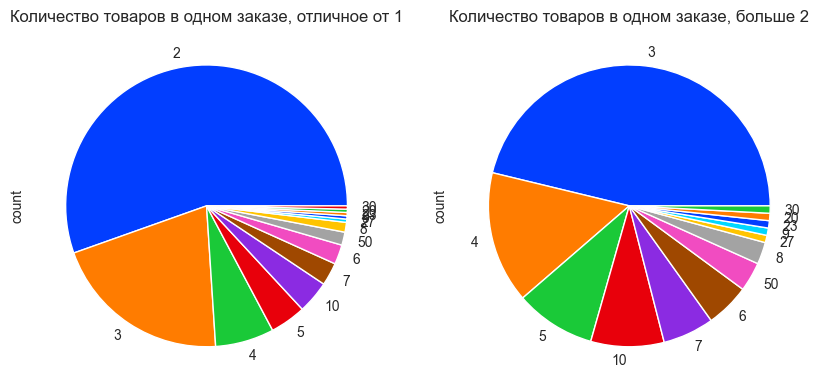

In [224]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
market.quantity.value_counts()[market.quantity.value_counts().index>1].plot(kind='pie', ax=axs[0],
 title = 'Количество товаров в одном заказе, отличное от 1')
market.quantity.value_counts()[market.quantity.value_counts().index>2].plot(kind='pie', ax=axs[1],
 title = 'Количество товаров в одном заказе, больше 2');

In [225]:
market.message_id.value_counts().to_frame()

,count
message_id,
1515915625557752721-1909-64942a0b0e7f5,180
1515915625536553210-2168-652e1b48c1307,144
1515915625562239366-1478-63d7db861a66e,129
1515915625578136559-2143-651e7e863e7b7,97
1515915625526260427-2060-64ec68f2d981e,89
...,...
1515915625542991565-1653-64214e782c4d3,1
1515915625519434981-1649-641d66d157a03,1
1515915625556725444-2033-64d615f571a5e,1


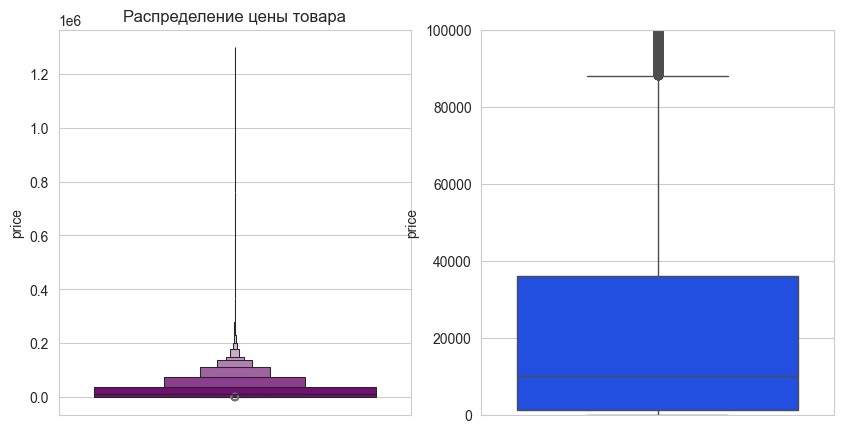

In [226]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(market.price, ax=axs[0], color='purple').set_title('Распределение цены товара')
sns.boxplot(market.price, ax=axs[1]).set_ylim(0, 100000);

In [227]:
print('средняя цена покупки:', round(market.price.mean()), 'медианная цена покупки:',
 round(market.price.median()))

средняя цена покупки: 27919 медианная цена покупки: 9998


In [228]:
market[market.date.dt.date!=market.created_at].shape[0]

0

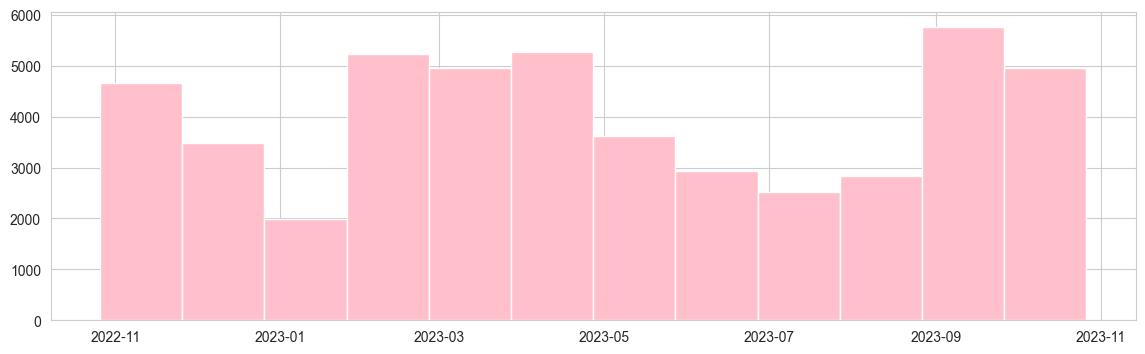

In [229]:
market.date.hist(figsize=(14, 4), bins=12, color='pink');

In [230]:
print('начальная дата покупок:', market.date.min(), 'последняя дата покупок:', market.date.max())

начальная дата покупок: 2022-10-26 08:35:46 последняя дата покупок: 2023-10-26 13:34:11


- итого:
  - в среднем на каждого клиента маркетплейса приходится 2.7 заказа
  - всего 17787 уникальных клиентов
  - 9399  совершили более одной покупки
  - в 99% заказов входит только одна позиции товара
  - распределение цены товара сильно смещено вправо, что подтверждает привышение практически в три раза средней цены к медианной, на графиках видим вероятность выбросов, необходимо посмотреть на слишком большие значения этого признака
  - столбец created_at является частью столбца date, без информации о времени, удалю его
  - распределение даты совершения покупок показывает, что мы имеем интервал равный одному году начиная с 26.10.22. Максимальные пики обозначились в ноябре 2022, феврале/марте/апреле/октябре 2023, самый максимум достигнут в сентябре 2023, минимальные - в январе/июле 2023 - из чего можно сделать предварительный вывод: меньше всего покупок на маркетплейсе совершается в начале года и летом, больше всего весной и осенью (что в принципе логично - спад идет в зимние каникулы и сезон отпусков, а рост на февральские/мартовские праздники и началу учебного года).

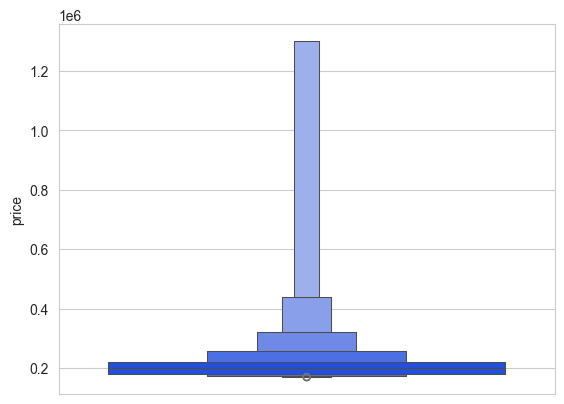

In [231]:
sns.boxenplot(market[market.price>np.percentile(market.price, 99)].price);

In [232]:
market[market.price>np.percentile(market.price, 99)].price.sort_values().to_frame()

,price
13914,168998.0
33998,169196.0
14243,169996.0
48057,169998.0
39661,169998.0
...,...
28734,1299998.0
28735,1299998.0
28736,1299998.0
28728,1299998.0


- после 99 процентиля идут большие суммы покупок, но я не считаю их "выбросными" и убирать из датасета не буду

In [233]:
market.drop('created_at', axis=1, inplace=True)

- датасет "магазин одежды"

In [234]:
apparel.shape[0]/apparel.client_id.nunique()

4.607109480461043

In [235]:
apparel.client_id.value_counts().to_frame(name='итого покупок:')

,итого покупок:
client_id,
1515915625853312319,275
1515915625624308268,218
1515915625607113301,210
1515915625500232103,113
1515915625490352441,111
...,...
1515915625550970797,1
1515915625489644065,1
1515915625860460896,1


In [236]:
apparel.client_id.value_counts()[apparel.client_id.value_counts()>1].count()

23830

In [237]:
apparel.quantity.value_counts()[apparel.quantity.value_counts().index==1].values/apparel.shape[0]

array([0.99728784])

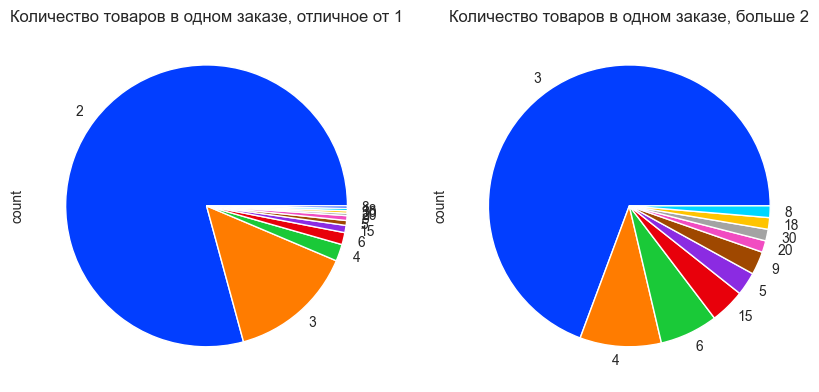

In [238]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
apparel.quantity.value_counts()[apparel.quantity.value_counts().index>1].plot(kind='pie', ax=axs[0],
 title = 'Количество товаров в одном заказе, отличное от 1')
apparel.quantity.value_counts()[apparel.quantity.value_counts().index>2].plot(kind='pie', ax=axs[1],
 title = 'Количество товаров в одном заказе, больше 2');

In [239]:
apparel.message_id.nunique()

25426

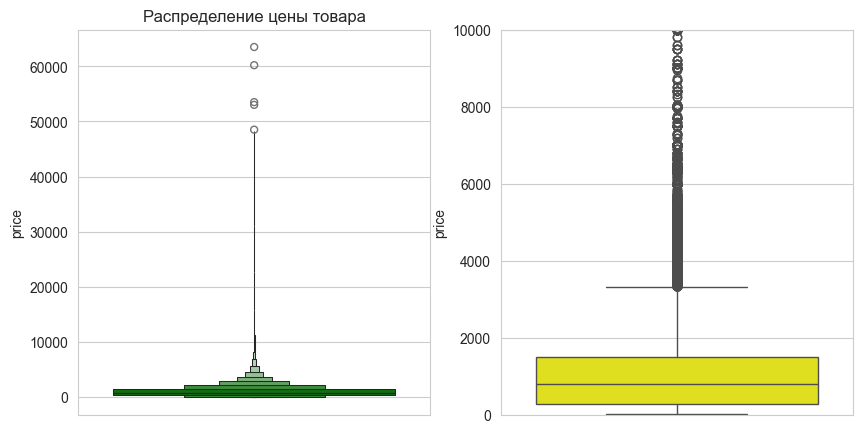

In [240]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(apparel.price, ax=axs[0], color='green').set_title('Распределение цены товара')
sns.boxplot(apparel.price, ax=axs[1], color='yellow').set_ylim(0, 10000);

In [241]:
print('средняя цена покупки:', round(apparel.price.mean()), 'медианная цена покупки:',
 round(apparel.price.median()))

средняя цена покупки: 1110 медианная цена покупки: 799


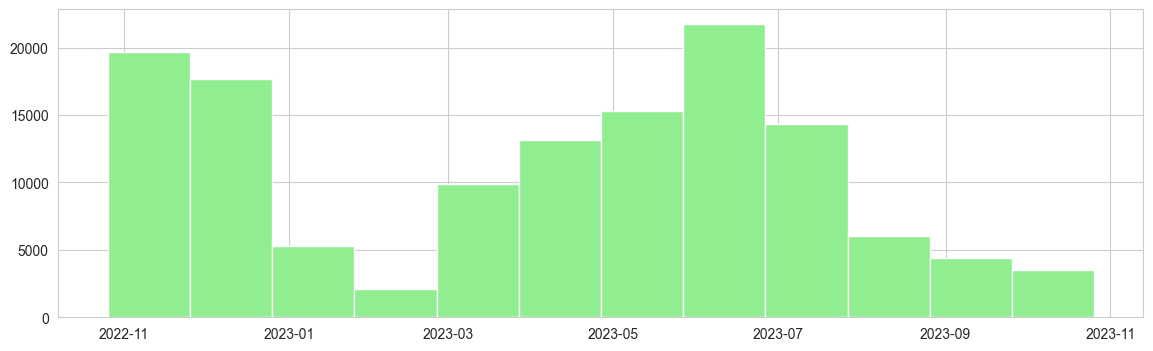

In [242]:
apparel.date.hist(figsize=(14, 4), bins=12, color='lightgreen');

In [243]:
print('начальная дата покупок:', apparel.date.min(), 'последняя дата покупок:', apparel.date.max())

начальная дата покупок: 2022-10-26 00:00:00 последняя дата покупок: 2023-10-26 00:00:00


In [244]:
apparel.recommended_by.unique()

array(['bulk_message'], dtype=object)

- итого:
  - в среднем на каждого клиента магазина одежды приходится 4.6 заказа(аналогично с маркетплейсом)
  - всего 28891 уникальный клиент
  - 23830 совершили более одной покупки
  - в 99% заказов входит только одна позиции товара
  - распределение цены товара смещено вправо, но не настолько как в датасете маркетплейса (среднее несильно превышает медиану)
  - столбец recommended_by имеет только одно уникальное значение и будет удален
  - распределение даты совершения покупок отличается от распределения в первом датасете. Большие значения показаны в ноябре/декабре 2022(предпраздничные покупки), затем идет резкий спад в январе/феврале 2023, с марта начинается планомерный рост количества продаж, достигающий своего пика в июне, затем следует спад до конца ряда.

In [245]:
#предобработка
apparel.drop('recommended_by', axis=1, inplace=True)

- датасет "магазин подарков"

In [246]:
gifts.shape[0]/gifts.client_id.nunique()

2.4877300613496933

In [247]:
gifts.client_id.value_counts().to_frame(name='итого покупок:')

,итого покупок:
client_id,
1515915625803894158,49
1515915625803892965,38
1515915625819603986,12
1515915625902774628,11
1515915625862783809,10
...,...
1515915625805526070,1
1515915625803214585,1
1515915625803273955,1


In [248]:
gifts.client_id.value_counts()[gifts.client_id.value_counts()>1].count()

151

In [249]:
gifts.quantity.value_counts()[gifts.quantity.value_counts().index==1].values/gifts.shape[0]

array([0.99630086])

In [250]:
gifts.quantity.value_counts().to_frame()

,count
quantity,
1,808
2,3


In [251]:
gifts.message_id.nunique()

342

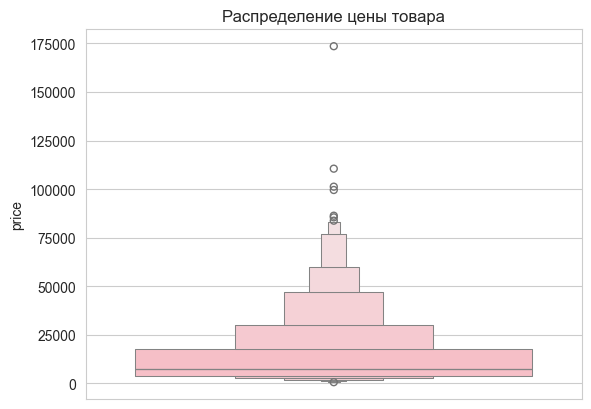

In [252]:
sns.boxenplot(gifts.price, color='lightpink').set_title('Распределение цены товара');

In [253]:
print('средняя цена покупки:', round(gifts.price.mean()), 'медианная цена покупки:',
 round(gifts.price.median()))

средняя цена покупки: 14469 медианная цена покупки: 7533


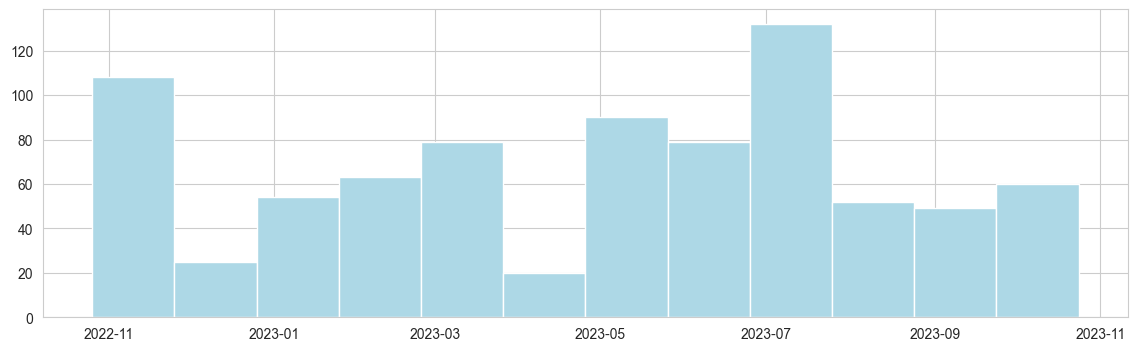

In [254]:
gifts.date.hist(figsize=(14, 4), bins=12, color='lightblue');

In [255]:
gifts.recommended_by.unique()

array(['bulk_message'], dtype=object)

- итого:
  - в среднем на каждого клиента магазина подарков приходится 2.5 заказа
  - всего 326 уникальныx клиентов
  - 151 совершили более одной покупки
  - в 99% заказов входит только одна позиции товара, второе значение этой категории - 2 товара
  - распределение цены товара сильно смещено вправо, (среднее болше медианы в два раза)
  - столбец recommended_by имеет только одно уникальное значение и будет удален
  - распределение даты совершения покупок - максимальные значения в июле/июне/мае, минимальные - в апреле/декабре

In [256]:
#предобработка
gifts.drop('recommended_by', axis=1, inplace=True)

***3. Анализ данных, выделение целевой переменной, отбор существующих и генерация новых признаков для итогового датасета:***

- в каждом из датасетов находится достаточное количество дубликатов. Из-за отсутствия более подробной информации о покупке, как например артикул товара, невозможно сделать однозначный вывод о том, дубликаты или это или например одинаковые предметы одежды в одном и том же количестве, в одном заказе, но разных размеров. Я ***пока*** не буду удалять дубликаты строк
- сначала объединю между собой три таблицы (но перед этим проверю чтобы айди клиентов между собой не пересекались), также заранее создам столбец тип магазина
- затем выделю в отдельные столбцы дату и месяц, при помощи библиотеки holidays создам бинарный столбец является ли день праздничным или предпраздничным
- так как было принято решение считать за одну покупку все покупки за весь день от 1 клиента, сгруппирую данные по айди клиента и дате для того, чтобы составить список клиентов, сделавших покупки в последний месяц
- затем удалю данные из датасета за этот месяц

In [257]:
market.client_id.isin(apparel.client_id).unique()

array([False])

In [258]:
market.client_id.isin(gifts.client_id).unique()

array([False])

In [259]:
gifts.client_id.isin(apparel.client_id).unique()

array([False])

In [260]:
market['type']=1
apparel['type'] = 2
gifts['type'] = 3
df_ = pd.concat([market, apparel, gifts])

In [261]:
df_['dates'] = df_.date.dt.date
df_.dates = pd.to_datetime(df_.dates)
df_['month'] = df_.dates.dt.month
df_['day'] = df_.dates.dt.day
df_['day_of_year'] = df_.dates.dt.day_of_year
df_['day_of_week'] = df_.dates.dt.dayofweek

In [262]:
holidays_list = []
for i in holidays.RUS(years=[2022, 2023]).items():
    holidays_list.append(str(i[0]))
holidays_list = holidays_list + ['2022-12-31', '2022-12-30', '2022-12-29', '2022-02-22', '2022-03-07',
 '2023-02-22', '2023-02-23', '2023-03-07']
df_['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in df_.dates]

In [263]:
grouped_df = df_.groupby(['client_id', 'dates'], as_index=False).agg({'type': ['first']})
list_id_last_month = grouped_df[grouped_df.dates>'2023-09-25'].client_id.tolist()
df_ = df_[df_.dates<='2023-09-25']

- теперь сгруппирую датасет по айди клиента, и сразу создам некоторые признаки:
  - общее количество купленных товаров
  - медианное количество купленных товаров
  - общая стоимость купленных товаров
  - средняя стоимость купленных товаров
  - медианная стоимость купленных товаров
  - первый/последний месяц/день/день в году/день недели покупки
- кроме того создам "синтетический" признак кадратный корень из медианной цены (на самом деле он единственный из такого рода признаков дал хоть какое-нибудь увеличение целевой метрики)
- и выведу бинарный таргет на основании сформированного раньше списка с айди клиентов, сделавших покупку в последнем месяце

In [264]:
df = df_.groupby('client_id', as_index=False).agg(sum_quantity = ('quantity', 'sum'),\
          median_quantity = ('quantity', 'median'), sum_price = ('price', 'sum'),\
               mean_price = ('price', 'mean'), median_price = ('price', 'median'),\
                    type = ('type', 'first'), first_date=('dates', 'first'),
                    last_date=('dates', 'last'), first_month = ('month', 'first'),\
                         last_month = ('month', 'last'), first_day = ('day', 'first'),\
                              last_day = ('day', 'last'), first_day_of_year = ('day_of_year', 'first'),\
               last_day_of_year = ('day_of_year', 'last'), first_day_of_week = ('day_of_week', 'first'),\
               last_day_of_week = ('day_of_week', 'last'), is_holiday = ('is_holiday', 'first'),\
               message_id= ('message_id', 'first'), max_price = ('price', 'max'))
df.mean_price = df.mean_price.round(2)
df['sqrt_med_price'] = np.sqrt(df.median_price)
df['target'] = [1 if x in list_id_last_month else 0 for x in df.client_id]

- теперь разделю выборку на тренировочную и тестовую части. отделю категориальные и численные признаки, первые закодирую таргет энкодером, вторые нормализую стандарт скалером.

In [265]:
X = df.drop(['client_id', 'target'], axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [266]:
cat = []
num = []
for x in X_train.columns:
    if X_train[x].dtype in ['datetime64[ns]', 'object']:
        cat.append(x)
    if X_train[x].dtype in ['int32', 'int64', 'float64']:
        num.append(x)

In [267]:
enc = TargetEncoder(random_state=random_state)
X_train_enc = pd.DataFrame(enc.fit_transform(X_train[cat], y=y_train),\
    columns=enc.get_feature_names_out(X_train[cat].columns), index = X_train[cat].index)
X_test_enc = pd.DataFrame(enc.transform(X_test[cat]), columns=enc.get_feature_names_out(X_train[cat]\
    .columns), index = X_test[cat].index)
scaler = StandardScaler()
X_train_scal = pd.DataFrame(scaler.fit_transform(X_train[num]),
 columns=scaler.get_feature_names_out(X_train[num].columns), index=X_train[num].index)
X_test_scal = pd.DataFrame(scaler.transform(X_test[num]),
 columns=scaler.get_feature_names_out(X_train[num].columns), index=X_test[num].index)
X_train = pd.concat([X_train_enc, X_train_scal], axis=1)
X_test = pd.concat([X_test_enc, X_test_scal], axis=1)

***4. Кроссвалидация-моделей, выбор лучшей, оценка важности признаков***

- проведу кроссвалидацию, используя наивную модель, модель логистической регресии, модели градиентного бустинга от lightgbm и catboost (сбалансированные и нет)

In [268]:
index = []
scores = {"Recall": [], "Precision": [], "ROC-AUC": [], "F1": []}
scoring = ["recall", "precision", "roc_auc", "f1"]

In [269]:
dummy_clf = DummyClassifier(strategy="most_frequent")

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.0,0.0,0.5,0.0


In [270]:
lr_clf = LogisticRegression(max_iter=1000, random_state=random_state)
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.00000,0.000000,0.500000,0.000000
Logistic regression,0.05026,0.640833,0.799764,0.091935


In [271]:
lr_bal = lr_clf.set_params(class_weight="balanced", random_state=random_state)
index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_bal, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.000000,0.000000,0.500000,0.000000
Logistic regression,0.050260,0.640833,0.799764,0.091935
Logistic regression with balanced class weights,0.783904,0.036330,0.810988,0.069438


In [272]:
lgbm_clf = LGBMClassifier(random_state=random_state)
index += ["LGBM"]
cv_result = cross_validate(lgbm_clf, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.000000,0.000000,0.500000,0.000000
Logistic regression,0.050260,0.640833,0.799764,0.091935
Logistic regression with balanced class weights,0.783904,0.036330,0.810988,0.069438
LGBM,0.100623,0.533081,0.823054,0.168744


In [273]:
lgbm_clf_bal = LGBMClassifier(random_state=random_state, class_weight='balanced')
index += ["LGBM_balanced"]
cv_result = cross_validate(lgbm_clf_bal, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.000000,0.000000,0.500000,0.000000
Logistic regression,0.050260,0.640833,0.799764,0.091935
Logistic regression with balanced class weights,0.783904,0.036330,0.810988,0.069438
LGBM,0.100623,0.533081,0.823054,0.168744
LGBM_balanced,0.459778,0.097295,0.808592,0.160523


In [274]:
cat_clf = CatBoostClassifier(random_state=random_state, verbose=0)
index += ["CAT"]
cv_result = cross_validate(cat_clf, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.000000,0.000000,0.500000,0.000000
Logistic regression,0.050260,0.640833,0.799764,0.091935
Logistic regression with balanced class weights,0.783904,0.036330,0.810988,0.069438
LGBM,0.100623,0.533081,0.823054,0.168744
LGBM_balanced,0.459778,0.097295,0.808592,0.160523
CAT,0.083818,0.651486,0.828499,0.148342


In [275]:
cat_clf_bal = CatBoostClassifier(random_state=random_state, verbose=0, auto_class_weights='Balanced')
index += ["CAT_balanced"]
cv_result = cross_validate(cat_clf_bal, X_train, y_train, scoring=scoring)
scores["Recall"].append(cv_result['test_recall'].mean())
scores["Precision"].append(cv_result['test_precision'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
scores["F1"].append(cv_result['test_f1'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall,Precision,ROC-AUC,F1
Dummy classifier,0.000000,0.000000,0.500000,0.000000
Logistic regression,0.050260,0.640833,0.799764,0.091935
Logistic regression with balanced class weights,0.783904,0.036330,0.810988,0.069438
LGBM,0.100623,0.533081,0.823054,0.168744
LGBM_balanced,0.459778,0.097295,0.808592,0.160523
CAT,0.083818,0.651486,0.828499,0.148342
CAT_balanced,0.264486,0.137660,0.792173,0.180941


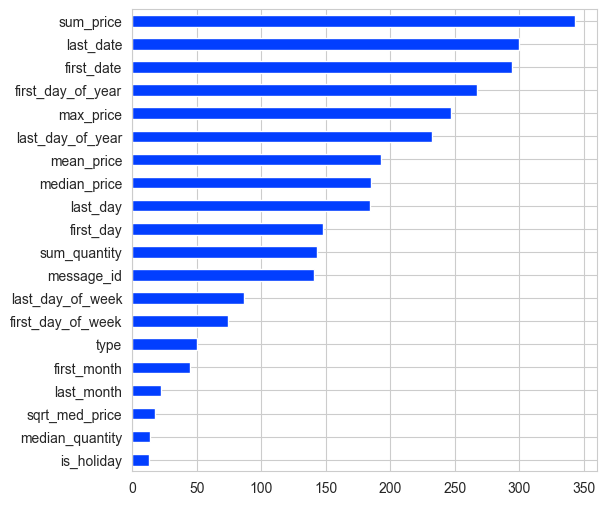

In [276]:
lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced')
lgbm.fit(X_train, y_train)
pd.DataFrame(data={'score': lgbm.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False);

In [277]:
feature_list = X_train.columns.tolist()
lgbm.fit(X_train, y_train)
best_metric = f1_score(y_test, lgbm.predict(X_test))
features = []
for x in feature_list:
    lgbm.fit(X_train.drop(x, axis=1), y_train)
    metric = f1_score(y_test, lgbm.predict(X_test.drop(x, axis=1)))
    if metric > best_metric:
        best_metric = metric
        features.append(x)
print(best_metric, features)  

0.17518248175182483 ['first_date']


- итого по результатам кроссвалидации видно, что лучшая целева метрика (рок-аук) у моделей градиентного спуска, причем у CatClassifier она немногим выше LGBM, но для тестирования я выберу именно последнюю модель поскольку метрика F1 у нее более устойчива при изменении параметра балансировки
- на визуализации важности признаков для модели видно какие из них наиболее важны: это общая стоимость купленных товаров, первая и последняя дата покупки (скорее их распределение энкодером относительно таргета)
- по последнему циклу видим, что в принципе можно убрать столбец с первой датой, чтобы немного увеличить метрику гармоничного сочетания охвата и точности

***5. Тестирование моделей, построение и анализ матриц ошибок, анализ shap-коэффициентов***

- здесь я проведу тестирование модели LGBM со сбалансированными весами и нет, выведу целевые метрики, сделаю классификационный отчет и построю матрицу ошибок для каждой, так же я попробую сама сбаланисровать соотношение классов и проанализирую полученный результат

In [278]:
lgbm_clf.fit(X_train, y_train)
roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])

0.8017922333723873

In [279]:
print(classification_report(y_test, lgbm_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8790
           1       0.56      0.07      0.13       134

    accuracy                           0.99      8924
   macro avg       0.77      0.54      0.56      8924
weighted avg       0.98      0.99      0.98      8924



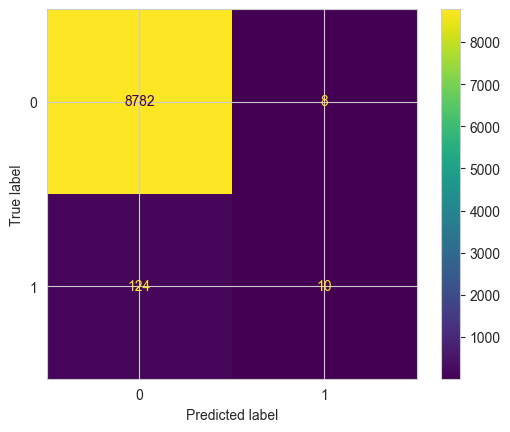

In [280]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lgbm_clf.predict(X_test))).plot()
plt.show()

In [281]:
lgbm_clf_bal.fit(X_train, y_train)
roc_auc_score(y_test, lgbm_clf_bal.predict_proba(X_test)[:,1])

0.7975243237736234

In [282]:
print(classification_report(y_test, lgbm_clf_bal.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8790
           1       0.09      0.47      0.15       134

    accuracy                           0.92      8924
   macro avg       0.54      0.70      0.55      8924
weighted avg       0.98      0.92      0.95      8924



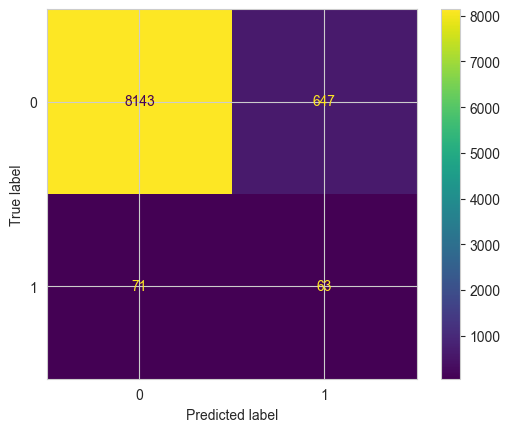

In [283]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lgbm_clf_bal.predict(X_test))).plot()
plt.show()

- теперь выполню передискретизацию с заменой (она дает такой же результат как и передисеретизация SMOTE, но так как для imbalance нужна более старая версия склерна, а для других инструментов его последняя версия, я сделала так)

In [284]:
print(X[y==0].shape)
print(X[y==1].shape)
x_resampled = resample(X_train[y==1], n_samples=X_train[y_train==0].shape[0], random_state=random_state)
x_ = pd.concat((X_train[y_train==0], x_resampled))
y_ = pd.concat((y_train[y_train==0], pd.Series(np.ones(shape=(X_train[y_train==0].shape[0],),
 dtype=np.int32))))
print(x_[y==0].shape)
print(x_[y==1].shape)

(43948, 20)
(671, 20)
(35158, 20)
(35158, 20)


In [285]:
lgbm_clf.fit(x_, y_)
roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])

0.7905307082335761

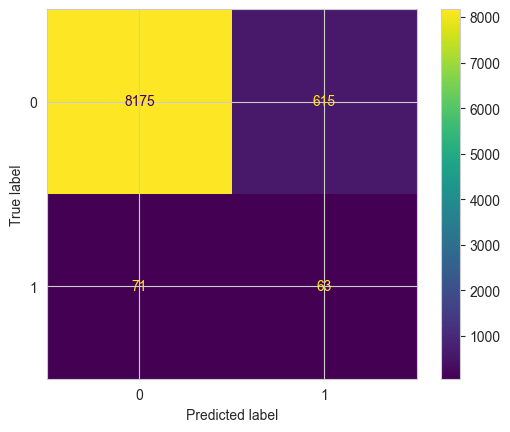

In [286]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lgbm_clf.predict(X_test))).plot()
plt.show()

- итого по результатам тестирования видно, что:
  - целевая метрика снизилась не значительно по сравнению с валидацией
  - сбалансированная модель дает меньшее количество ошибок по положительному классу по сравнению с несбалансированной
  - передискредитация дает такой же результат как и сбалансированная модель градиентного бустинга
- теперь посмотрю на shap-коэффициенты:

In [287]:
explainer_for_lgbm = shap.Explainer(lgbm, X_train)
shap_values_lgbm = explainer_for_lgbm(X_train, check_additivity=False)

 99%|===================| 35446/35695 [01:23<00:00]        

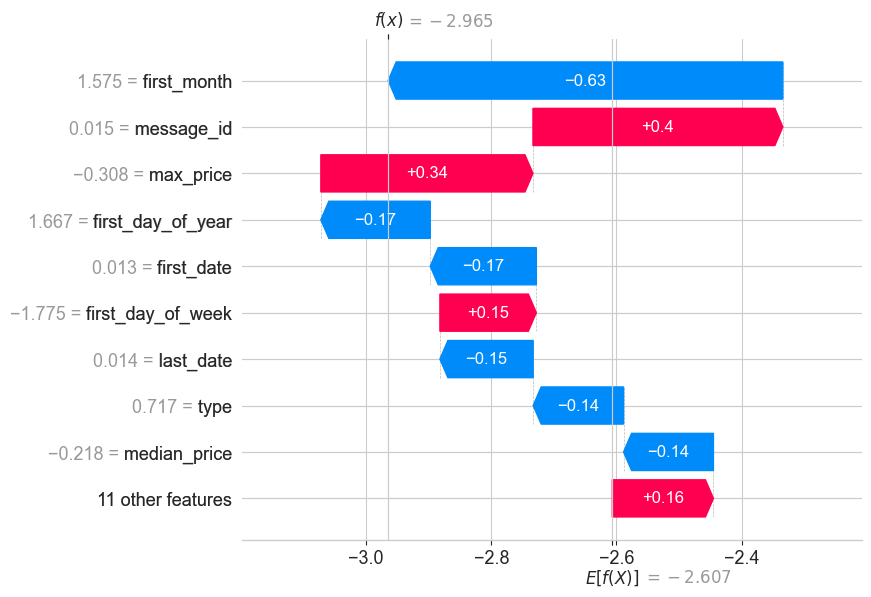

In [288]:
shap.plots.waterfall(shap_values_lgbm[0])

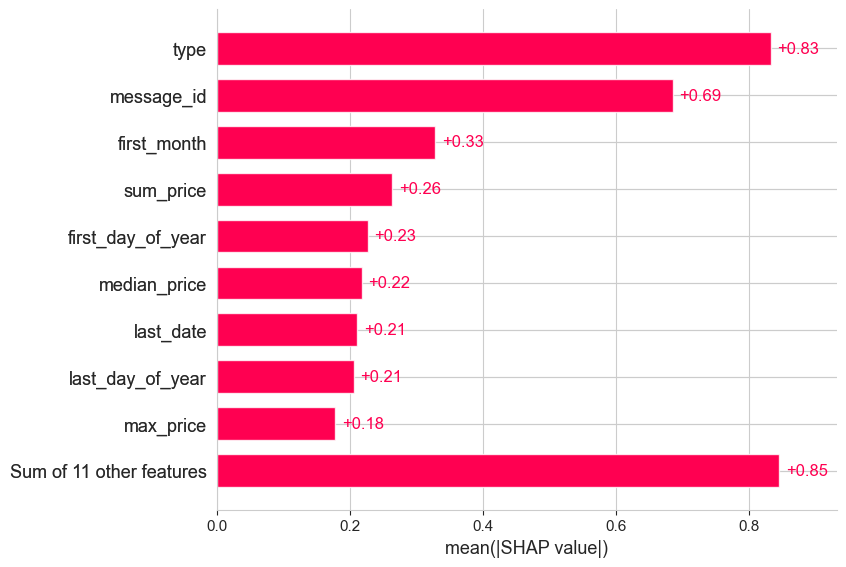

In [289]:
shap.plots.bar(shap_values_lgbm)

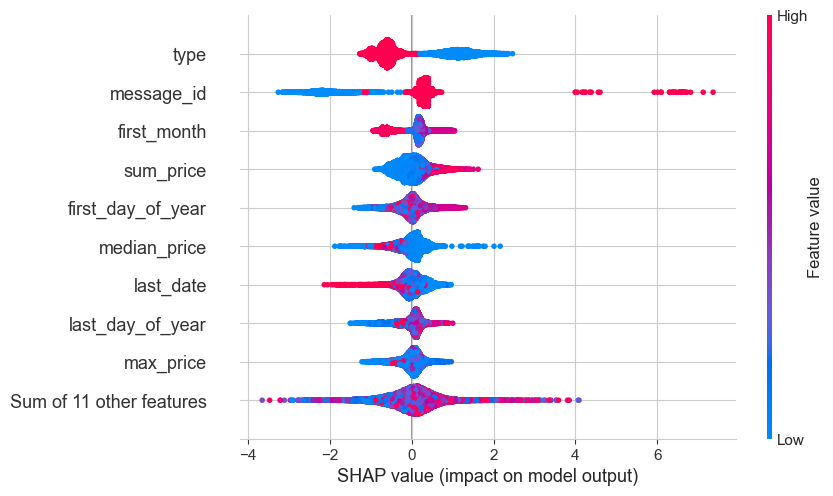

In [290]:
shap.plots.beeswarm(shap_values_lgbm)

- по значениям шап видно, что наиболее важными для определение положительного класса являются такие признаки как message_id, первый месяц покупки, общая стоимость покупки; для всей классификации важен признак с типом магазина.

***6. Общие выводы по проекту:***

- открыто три датасета с инофрмацией о покупках в маркет-плейсе/магазине одежды/магазине подарков, содержащие 6 столбцов и 48182/133104/811 строк данных соотвественно. Признаки, содержащие информацию о времени сразу переведены во временной тип
- по результатам EDA покупок в маркет-плейсе выявлено:
  - в среднем на каждого клиента маркетплейса приходится 2.7 заказа
  - всего 17787 уникальных клиентов
  - 9399  совершили более одной покупки
  - в 99% заказов входит только одна позиции товара
  - распределение цены товара сильно смещено вправо, что подтверждает привышение практически в три раза средней цены к медианной, на графиках видим вероятность выбросов, необходимо посмотреть на слишком большие значения этого признака
  - столбец created_at является частью столбца date, без информации о времени, удалю его
  - распределение даты совершения покупок показывает, что мы имеем интервал равный одному году начиная с 26.10.22. Максимальные пики обозначились в ноябре 2022, феврале/марте/апреле/октябре 2023, самый максимум достигнут в сентябре 2023, минимальные - в январе/июле 2023 - из чего можно сделать предварительный вывод: меньше всего покупок на маркетплейсе совершается в начале года и летом, больше всего весной и осенью (что в принципе логично - спад идет в зимние каникулы и сезон отпусков, а рост на февральские/мартовские праздники и началу учебного года)
- по результатам EDA покупок в магазине одежды:
  - в среднем на каждого клиента магазина одежды приходится 4.6 заказа(аналогично с маркетплейсом)
  - всего 28891 уникальный клиент
  - 23830 совершили более одной покупки
  - в 99% заказов входит только одна позиции товара
  - распределение цены товара смещено вправо, но не настолько как в датасете маркетплейса (среднее несильно превышает медиану)
  - столбец recommended_by имеет только одно уникальное значение и будет удален
  - распределение даты совершения покупок отличается от распределения в первом датасете. Большие значения показаны в ноябре/декабре 2022(предпраздничные покупки), затем идет резкий спад в январе/феврале 2023, с марта начинается планомерный рост количества продаж, достигающий своего пика в июне, затем следует спад до конца ряда
- по результатам EDA покупок в магазине подарков:
  - в среднем на каждого клиента магазина подарков приходится 2.5 заказа
  - всего 326 уникальныx клиентов
  - 151 совершили более одной покупки
  - в 99% заказов входит только одна позиции товара, второе значение этой категории - 2 товара
  - распределение цены товара сильно смещено вправо, (среднее болше медианы в два раза)
  - столбец recommended_by имеет только одно уникальное значение и будет удален
  - распределение даты совершения покупок - максимальные значения в июле/июне/мае, минимальные - в апреле/декабре
- в каждом из датасетов находится достаточное количество дубликатов. Из-за отсутствия более подробной информации о покупке, как например артикул товара, невозможно сделать однозначный вывод о том, дубликаты или это или например одинаковые предметы одежды в одном и том же количестве, в одном заказе, но разных размеров. Поэтому я не стала их удалять.
- объединила между собой три таблицы, заранее создав столбец тип магазина
- при помощи библиотеки holidays создала бинарный столбец является ли день праздничным или предпраздничным
- так как было принято решение считать за одну покупку все покупки за весь день от 1 клиента, сгруппировала данные по айди клиента и дате для того, чтобы составить список клиентов, сделавших покупки в последний месяц и удалила данные из датасета за этот месяц
- затем сгруппировала датасет по айди клиента, и сщздала некоторые признаки:
  - общее количество купленных товаров
  - медианное количество купленных товаров
  - общая стоимость купленных товаров
  - средняя стоимость купленных товаров
  - медианная стоимость купленных товаров
  - первый/последний месяц/день/день в году/день недели покупки
- кроме того создала "синтетический" признак кадратный корень из медианной цены (на самом деле он единственный из такого рода признаков дал хоть какое-нибудь увеличение целевой метрики)
- вывела бинарный таргет на основании сформированного раньше списка с айди клиентов, сделавших покупку в последнем месяце
- затем разделила выборку на тренировочную и тестовую части. Отделила категориальные и численные признаки, первые закодировала таргет энкодером, вторые нормализовала стандарт скалером
- провела кроссвалидацию, используя наивную модель, модель логистической регресии, модели градиентного бустинга от lightgbm и catboost (сбалансированные и нет)
- по результатам кроссвалидации для тестирования я выбрала модель LGBM, поскольку несмотря на то, что она имела сравнимые показатели целевой метрики с классификатором от CatBoost, метрика F1 у нее более устойчива при изменении параметра балансировки(roc-auc(несбалансированной модели)- 0.82, сбалансированной - 0.81, f1 - 0.17/0.16)
- визуализировала важность признаков для моделии определили наиболее важные: это общая стоимость купленных товаров, первая и последняя дата покупки (скорее их распределение энкодером относительно таргета)
- провела тестирование модели LGBM со сбалансированными весами и нет и получила результаты: roc-auc(несбалансированной модели)- 0.8, сбалансированной - 0.8, f1-0.13/0.15; соотношение ошибок предсказания положительного класса (верно/неверно) - 10/124 и 63/71
- передискредитация дала тот же результат, что и сбалансированная модель
- показатели shap обозначили, что наиболее важными признаками для определения именно положительного класса стали месседж-айди, суммарная сумма покупки и значение первого месяца совершения покупки.